# Naive Bayes' Classifier
- [Bernoulli NB](#BNB)
- [Gaussian NB](#GNB)
- [Multinomial NB](#MNB)

In [1]:
import itertools
import functools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(1234)
%matplotlib inline

## <a id="BNB"></a>Bernoulli NB

### Parameter Estimation - Both Incorporating Correction

- Class conditional density :

    $$
        w_{jy_{c}} = \frac {\sum\limits_{i=1}^n \mathbb{1}(y^{(i)} = y_c)x_j^{(i)} + \alpha} {\sum\limits_{i=1}^n \mathbb{1}(y^{(i)} = y_c) + 2\alpha}
    $$

    **NOTE :** $\mathbb{1}(y^{(i)} = y_c)$  = 1 if $(y^{(i)} = y_c)$ and 0 otherwise

<br>

- Class prior :

    $$
        w_{jc} = \frac {\sum\limits_{i=1}^n \mathbb{1}(y^{(i)} = y_c) + \alpha} {n + k\alpha}
    $$
    
For Laplace smoothing or correction, $\alpha = 1$

### Inference

**Determine Class Label**

We assign class label $y_c$ that results in the largest product of likelihood and prior


$$
y_c = argmax_{y_c}\left( \sum\limits_{j=1}^{n} log p(x_j | y_c; \textbf w)  \right) + log p(y_c; \textbf w)
$$

$$
y_c = argmax_{y_c}\left( \sum\limits_{j=1}^{n} log w_{j_{y_c}}^{x_j}(1 - w_{j_{y_c}})^{1 - x_j})  \right) + log p(y_c; \textbf w)
$$

$$
y_c = argmax_{y_c}\left( \sum\limits_{j=1}^{n} [x_j log w_{j_{y_c}} + (1 - x_j) (1 - w_{j_{y_c}})]  \right) + log p(y_c; \textbf w)
$$

Note that we perform these computations in **log space to avoid problem with overflow**

Further with vectorization. this is implemented as follows :

$$
    \textbf y = argmax_y \left(\textbf Xlog(\textbf w^{T}) + (1 - \textbf X)log(1 - \textbf w)^{T} + log(\textbf w_{prior}) \right)
$$



**NOTE :** In the estimation of $w_{jy_c}$ : We have vectorized the operation and we obtain $w_{y_c}$ that contains $w_{jy_c}$ for each $x_j$

In [5]:
def fit(X, y) :
    alpha = 1 # Laplace Smoothing
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    w = np.zeros((n_classes, n_features), dtype=np.float64)
    w_priors = np.zeros(n_classes, dtype=np.float64)
    
    for c in range(n_classes) :
        X_c = X[y == c]
        # Refer NOTE
        w[c, :] = (np.sum(X_c, axis=0) + alpha) / (X_c.shape[0] + n_classes * alpha)
        w_priors[c] = (X_c.shape[0] + alpha) / (float(n_samples) + n_classes * alpha)
        
        print("\nWeight Vector : \n", w)
        print("\nPrior : \n", w_priors)
        
    return w, w_priors

# Testing
X = np.array([[1,0],[0,1],[0,1],[1,0]])
y = np.array([1,0,0,1])
fit(X, y)


Weight Vector : 
 [[0.25 0.75]
 [0.   0.  ]]

Prior : 
 [0.5 0. ]

Weight Vector : 
 [[0.25 0.75]
 [0.75 0.25]]

Prior : 
 [0.5 0.5]


(array([[0.25, 0.75],
        [0.75, 0.25]]),
 array([0.5, 0.5]))

In [6]:
class BernoulliNB() :
    def __init__(self, alpha=1.0) :
        self.alpha = alpha
        
    def fit(self, X, y) :
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        self.w = np.zeros((n_classes, n_features), dtype=np.float64)
        self.w_priors = np.zeros(n_classes, dtype=np.float64)

        for c in range(n_classes) :
            X_c = X[y == c]
            # Refer NOTE
            self.w[c, :] = (np.sum(X_c, axis=0) + self.alpha) / (X_c.shape[0] + n_classes * self.alpha)
            self.w_priors[c] = (X_c.shape[0] + self.alpha) / (float(n_samples) + n_classes * self.alpha)

            print("\nClass Conditional Density : \n", self.w)
            print("\nPrior : \n", self.w_priors)

        return self.w, self.w_priors
    
    def log_likelihood_prior_prod(self, X) :
        return X @ np.log(self.w.T) + (1 - X) @ np.log(1 - self.w.T) + np.log(self.w_priors.T)
    
    def predict(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.argmax(q, axis=1)

    def predict_proba(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q) / np.expand_dims(np.sum(np.exp(q), axis=1), axis=1)

#### Binary Classification with BernoulliNB Example

In [7]:
X = np.array([[1,0],[0,1],[0,1],[1,0]])
y = np.array([1,0,0,1])

bernoulli_nb = BernoulliNB()
print("FIT : ")
print(bernoulli_nb.fit(X, y))
print("\nPREDICT : ")
print(bernoulli_nb.predict(X)) # Note the prediction is matching with the input labels
print("\nLOG LIKELIHOOD PRIOR PROD : ")
print(bernoulli_nb.log_likelihood_prior_prod(X))
print("\nPREDICTED PROBABILITIES : ")
print(bernoulli_nb.predict_proba(X))

FIT : 

Class Conditional Density : 
 [[0.25 0.75]
 [0.   0.  ]]

Prior : 
 [0.5 0. ]

Class Conditional Density : 
 [[0.25 0.75]
 [0.75 0.25]]

Prior : 
 [0.5 0.5]
(array([[0.25, 0.75],
       [0.75, 0.25]]), array([0.5, 0.5]))

PREDICT : 
[1 0 0 1]

LOG LIKELIHOOD PRIOR PROD : 
[[-3.4657359  -1.26851133]
 [-1.26851133 -3.4657359 ]
 [-1.26851133 -3.4657359 ]
 [-3.4657359  -1.26851133]]

PREDICTED PROBABILITIES : 
[[0.1 0.9]
 [0.9 0.1]
 [0.9 0.1]
 [0.1 0.9]]


#### Multi-class classification with Bernoulli Naive Bayes

In [36]:
X = np.array([[1,0],[0,1],[0,1],[1,0],[1,1],[1,1]])
y = np.array([1,0,0,1,2,2])

bernoulli_nb = BernoulliNB()
print("FIT : ")
print(bernoulli_nb.fit(X, y))
print("\nPREDICT : ")
print(bernoulli_nb.predict(X)) # Note the prediction is matching with the input labels
print("\nLOG LIKELIHOOD PRIOR PROD : ")
print(bernoulli_nb.log_likelihood_prior_prod(X))
print("\nPREDICTED PROBABILITIES : ")
print(bernoulli_nb.predict_proba(X))

FIT : 

Class Conditional Density : 
 [[0.2 0.6]
 [0.2 0.6]
 [0.2 0.6]]

Prior : 
 [0.33333333 0.         0.        ]

Class Conditional Density : 
 [[0.2 0.6]
 [0.6 0.2]
 [0.6 0.2]]

Prior : 
 [0.33333333 0.33333333 0.        ]

Class Conditional Density : 
 [[0.2 0.6]
 [0.6 0.2]
 [0.6 0.6]]

Prior : 
 [0.33333333 0.33333333 0.33333333]
(array([[0.2, 0.6],
       [0.6, 0.2],
       [0.6, 0.6]]), array([0.33333333, 0.33333333, 0.33333333]))

PREDICT : 
[1 0 0 1 2 2]

LOG LIKELIHOOD PRIOR PROD : 
[[-3.62434093 -1.83258146 -2.52572864]
 [-1.83258146 -3.62434093 -2.52572864]
 [-1.83258146 -3.62434093 -2.52572864]
 [-3.62434093 -1.83258146 -2.52572864]
 [-3.21887582 -3.21887582 -2.12026354]
 [-3.21887582 -3.21887582 -2.12026354]]

PREDICTED PROBABILITIES : 
[[0.1 0.6 0.3]
 [0.6 0.1 0.3]
 [0.6 0.1 0.3]
 [0.1 0.6 0.3]
 [0.2 0.2 0.6]
 [0.2 0.2 0.6]]


## <a id="GNB"></a>Gaussian NB

### Parameterization :

Here the features have real numbers or continuous values. And we assume that **each feature, given a label is drawn from a Gaussian Distribution.** Formally, we write it as :

$$
x_j|y_r \sim \mathcal N(\mu, \sigma^2)
$$

There are 2 parameters : 
- Mean $\mu$ 
- Variance $\sigma$

There are $m$ x $k$ Gaussian Distribution - one for each feature and label
Total number of parametes : $2 \times m \times k$

### Alternate Parameterization through Multi-Variate Gaussian :

For each label, we can assume a multi-variate Gaussian distribution with $m$ variables. Such a distribution will have :

- A **Mean Vector ($\mu$)** with $m$ components - one mean per feature
- A **Covariance Matrix ($\Sigma)$** with $m$ x $m$ entries  - 
    - However, since we are making a conditional independence assumption among variables, **the covariance matrix is assumed to be diagonal** :
        - Off diagonal entries are 0. $\Sigma_{jr} = 0$ where $j \neq r$
        - Diagonal entries denote the variance. $\Sigma_{jr} = \sigma_{j}^2$

In this scheme, we need to estimate :
- $m$ means and
- $m$ variances


As such the number of parameters are the same in both the representation. However, the **latter representation is more efficient in terms of computation**

### Parameter Estimation

Let $n_r$ be the **total number of sample with label** $y_r$

$$
    n_r = \sum\limits_{i=1}^{n} \mathbb{1}(y^{(i)} = y_r)
$$

The parameters for **multivariate Gaussian** for label $r$ can be calculated as follows :

$$
    \mu_r = \frac {1}{n_r}\sum\limits_{i=1}^{n} \mathbb{1}(y^{(i)} = y_r)\textbf x^{(i)}
$$

$$
    \Sigma_{jjr}^{2} = \frac {1}{n_r}\sum\limits_{i=1}^{n} \mathbb{1}(y^{(i)} = y_r)(\textbf x^{(i)} - \mu_r)^{2}
$$

### Inference 


The posterior probabilty can be calculated based on Bayes' Theorem :

$$
    p(y = y_c | \textbf x) = \frac {p(\textbf x | y_c)p(y_c)} {p(\textbf x)}
$$

The likelihood is computed with the following formula :

$$
    p(x_j | y_c; \mu_{jc}, \sigma_{jc}^{2}) = \frac {1} {(2\pi)^{1/2}\sigma_{jc}} e^{\frac {1} {2} (\frac {x_j - \mu_{jc}} {\sigma_{jc}})^{2}}
$$

This can be implemented with multi-variate Gaussian distribution with diagonal covariance matrix :

$$
    p(x_j | y_c; \mu_c, \Sigma_c) = \frac {1} {(2\pi)^{d/2}(|\Sigma_c|)^{1/2}} e^{\frac {1} {2} (\textbf x - \mu_c)^{T}\Sigma_c^{-1}(\textbf x - \mu_c)}
$$

It is interesting to note that :
- We calculate the distance between the mean and the sample normalized variance : ${\frac {1} {2} (\textbf x - \mu_c)^{T}\Sigma_c^{-1}(\textbf x - \mu_c)}$
- We calculate the exponential pf this distance and convert it into probability by dividing it with : $(2\pi)^{d/2}(|\Sigma_c|)^{1/2}$

In [39]:
class gaussianNB() :
    def __init__(self, alpha=1.0):
            self.alpha = alpha
            
    def fit(self, X, y) :
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)
    
    
        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[c] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

        print("Mean:", self._mean)
        print("Variance:", self._var)
        print("Prior", self._priors)
        
    def _calc_pdf(self, class_idx, X):
        mean = self._mean[class_idx]
        var = np.diag(self._var[class_idx])
        z = np.power(2 * np.pi, X.shape[0] / 2) * np.power(np.linalg.det(var), 1/2)
        return (1/z) * np.exp(-0.5 * (X - mean).T @ (np.linalg.inv(var)) @ (X - mean))
    
    def _calc_prod_likelihood_prior(self, X):
        self.q = np.zeros((X.shape[0], len(self._classes)), dtype=np.float64)
        for x_idx, x in enumerate(X):
            for idx, c in enumerate(self._classes):
                self.q[x_idx, c] = (np.log(self._calc_pdf(idx, x)) + np.log(self._priors[idx]))
    
    def predict_proba(self, X):
        self._calc_prod_likelihood_prior(X)
        return np.exp(self.q) / np.expand_dims(np.sum(np.exp(self.q), axis=1), axis=1)
    
    def predict(self, X):
        self._calc_prod_likelihood_prior(X)
        return np.argmax(self.q, axis=1)

In [45]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=100, n_features=2, centers=[[5,5],[10,10]], cluster_std=1.5, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

gaussian_nb = gaussianNB()
print("FIT : \n")
print(gaussian_nb.fit(X, y))
print("\nPREDICT : \n")
print(gaussian_nb.predict(X))

from sklearn.metrics import classification_report
print()
print(classification_report(y_test, gaussian_nb.predict(X_test)))

FIT : 

Mean: [[ 4.55327074  5.13550586]
 [10.33985583 10.04486762]]
Variance: [[2.09245276 2.5775431 ]
 [3.36405042 2.13027877]]
Prior [0.5 0.5]
None

PREDICT : 

[0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1
 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0
 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



## <a id="MNB"></a>Multinomial NB

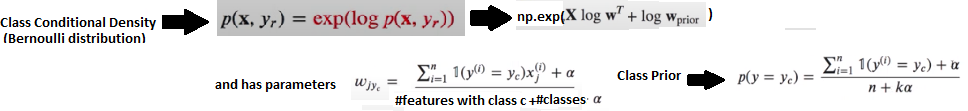

In [47]:
class MultinomialNB():
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        self.w = np.zeros((n_classes, n_features), dtype=np.float64)
        self.w_priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            total_count = np.sum(np.sum(X_c, axis=1))
            self.w[idx, :] = (np.sum(X_c, axis=0) + self.alpha) / (total_count + n_classes * self.alpha)
            self.w_priors[idx] = (X_c.shape[0] + self.alpha) / (float(n_samples) + n_classes * self.alpha)

    def log_likelihood_prior_prod(self, X):
        return X @ (np.log(self.w).T) + np.log(self.w_priors)
    
    def predict_proba(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q) / np.expand_dims(np.sum(np.exp(q), axis=1), axis=1)
    
    def predict(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.argmax(q, axis=1)